# Generating random sets for simulation a quantum state

In [1]:
import numpy as np


def get_rand(count):
    return [1 if i > 0.5 else 0 for i in np.random.random(count)]


np.random.seed(1234)

random_set1 = get_rand(10)
random_set2 = get_rand(25)
random_set3 = get_rand(50)



In [2]:
print("Set 1")
print(random_set1)
print("Set 2")
print(random_set2)
print("Set 3")
print(random_set3)


Set 1
[0, 1, 0, 1, 1, 0, 0, 1, 1, 1]
Set 2
[0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1]
Set 3
[1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1]



Cell order of cameras: 

V - Alice | H - Alice

V - Bob   | H - Bob

V - Alice = 1
H - Alice = 0



For the angle table
alpha - alice
beta - bob

In [3]:
np.random.seed(1235)
rands = [get_rand(20) for i in range(22)]
for i, r in enumerate(rands):
    print(f"Set number {i + 1}")
    print(r)

Set number 1
[1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1]
Set number 2
[1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1]
Set number 3
[1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0]
Set number 4
[1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0]
Set number 5
[1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]
Set number 6
[1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Set number 7
[0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0]
Set number 8
[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]
Set number 9
[0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0]
Set number 10
[0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0]
Set number 11
[0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]
Set number 12
[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0]
Set number 13
[1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
Set number 14
[0, 1, 0, 0, 1, 1, 0

 0 degrees = 0
 
 90 degrees = 1
 
the lists were mapped accordingly
actual index -> list index
1 -> 1

2 -> 2

3 -> 3

4 -> 17

5 -> 6

6 -> 7

7 -> 8

8 -> 18





Alice max angle - 308 degrees

Bob max angle - 20 degrees

test_max video was used here

Alice min angle - 218

Bob min angle - 110




# Processing red light from recorded videos

In [92]:
import os
import enum
import glob

import cv2
import tqdm
import matplotlib.pyplot as plt
import scipy as sp


class Sensor(enum.Enum):
    V_ALICE = enum.auto()
    V_BOB = enum.auto()
    H_ALICE = enum.auto()
    H_BOB = enum.auto()


RECTS = {
    Sensor.V_ALICE: np.array([496, 51, 331, 256]),
    Sensor.V_BOB: np.array([489, 422, 331, 241]),
    Sensor.H_ALICE: np.array([926, 61, 332, 248]),
    Sensor.H_BOB: np.array([928, 427, 328, 250]),
}


# calculates the red pixels intensity, by summing the intensity or red pixles
def calculate_red_intensity(frame, box):
    x, y, w, h = box
    roi = frame[y:y + h, x:x + w]

    red_channel = roi[:, :, 2]
    green_channel = roi[:, :, 1]
    blue_channel = roi[:, :, 0]

    # Consider red-dominant pixels only, using this arbitrary condition
    red_dominant = (red_channel / 1.5 > green_channel) & (red_channel / 1.5 > blue_channel)
    
    return np.sum([np.linalg.norm([red, green, blue]) for red, green, blue in
                   zip(red_channel[red_dominant], green_channel[red_dominant], blue_channel[red_dominant])])


video_directory = "data"

videos = [f for f in glob.glob(f"{video_directory}/*.mp4")]

intensities = {}

for video in tqdm.tqdm(videos):
    cap = cv2.VideoCapture(video)

    if not cap.isOpened():
        print(f"Unable to open video: {video}")
        continue

    file_name = os.path.basename(video).split(".")[0]
    current_intensities = {}
    intensities[file_name] = current_intensities
    while True:

        ret, frame = cap.read()
        if not ret:
            break

        for r in Sensor:
            if r not in current_intensities:
                current_intensities[r] = []
            intensity = calculate_red_intensity(frame, RECTS[r])
            current_intensities[r].append(intensity)
    cap.release()




100%|██████████| 19/19 [04:49<00:00, 15.25s/it]


# Finding peaks

peak count 15


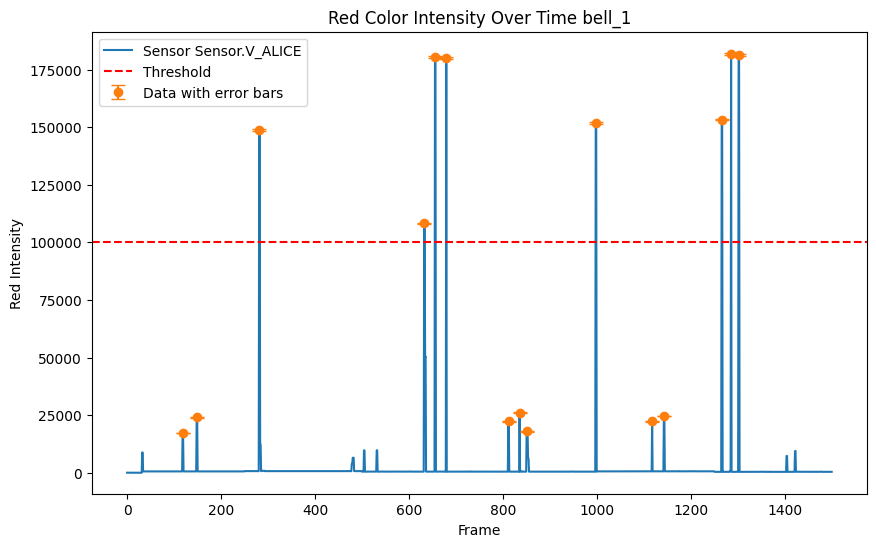

peak count 20


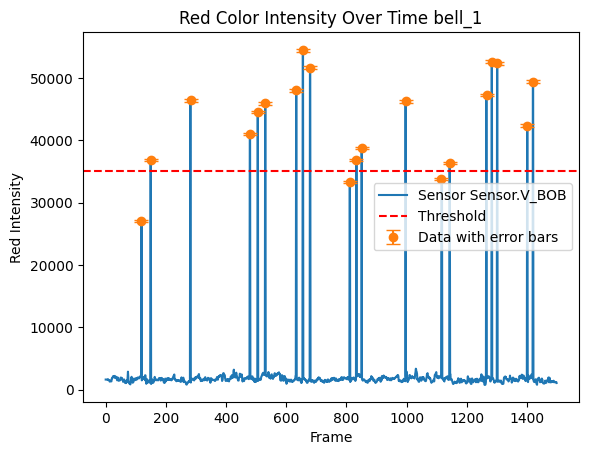

peak count 14


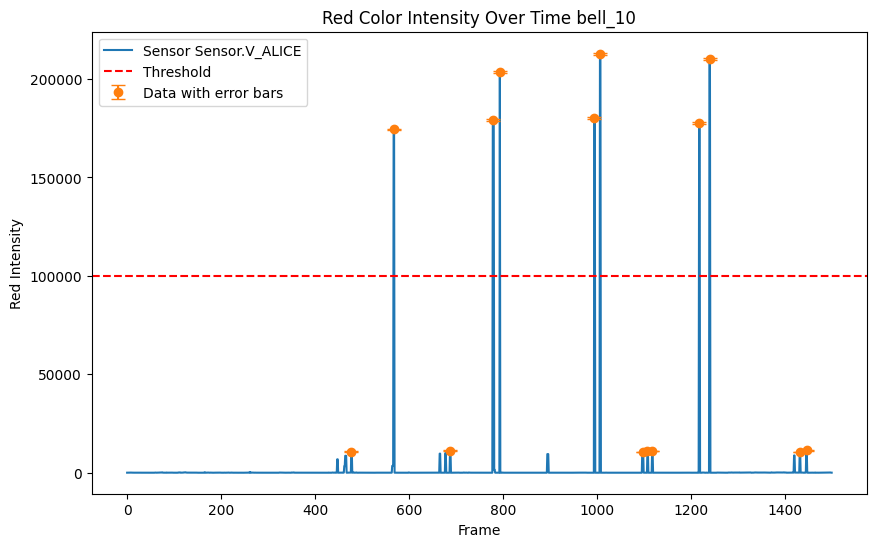

peak count 20


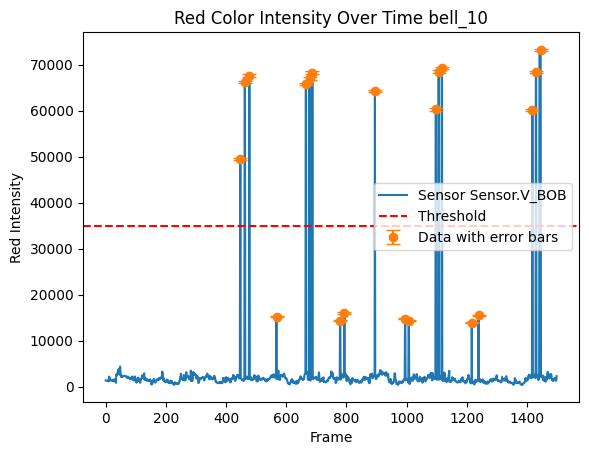

peak count 16


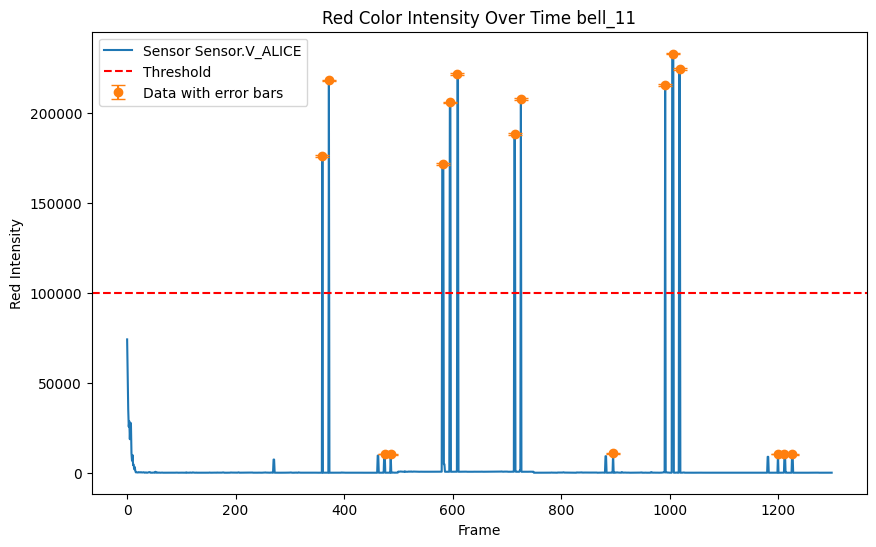

peak count 20


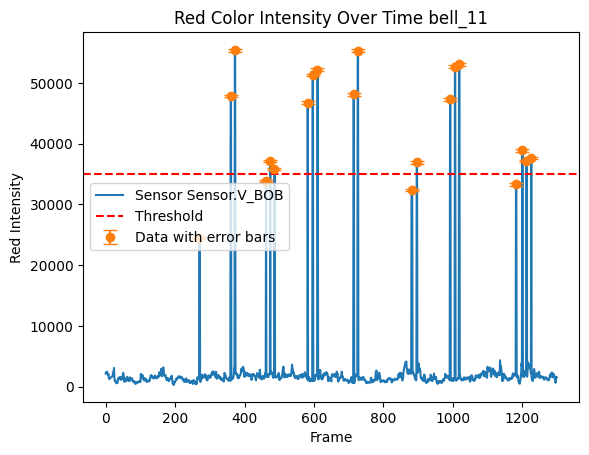

peak count 17


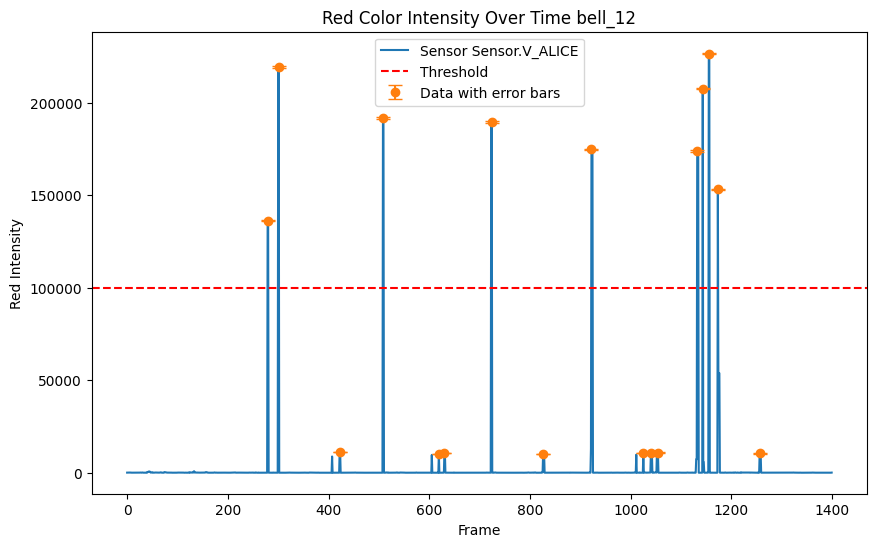

peak count 9


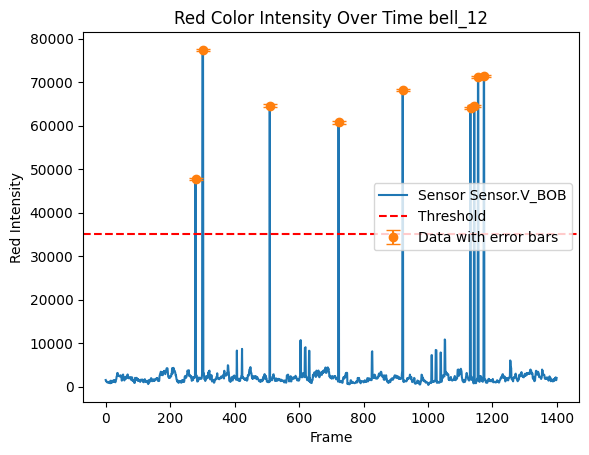

peak count 20


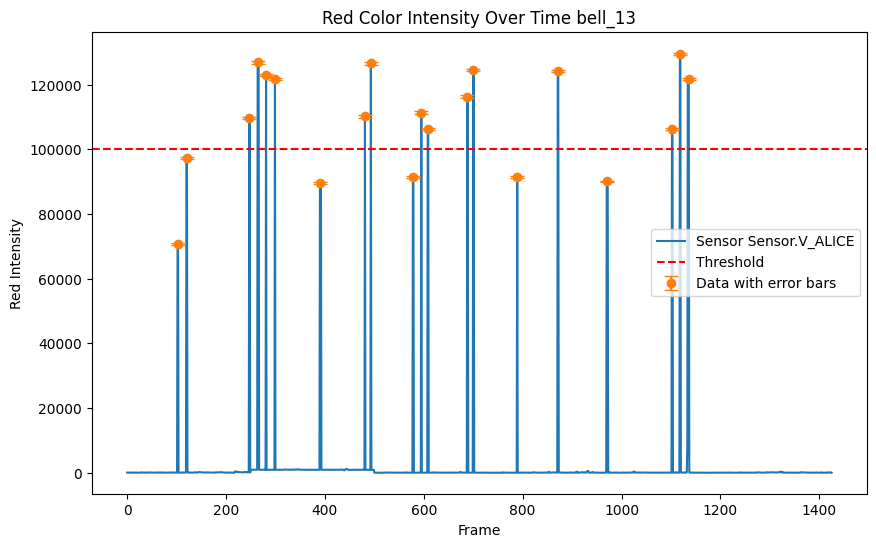

peak count 20


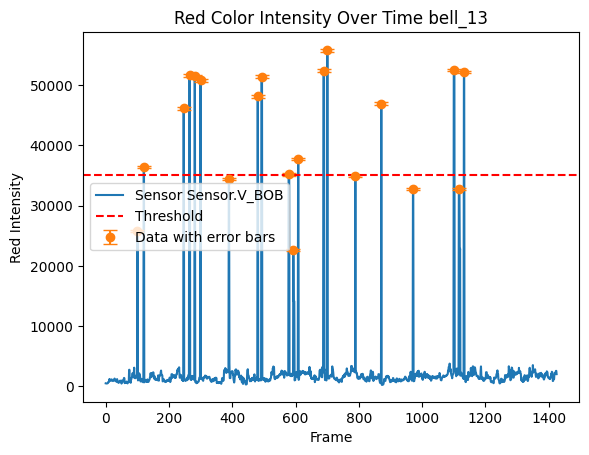

peak count 20


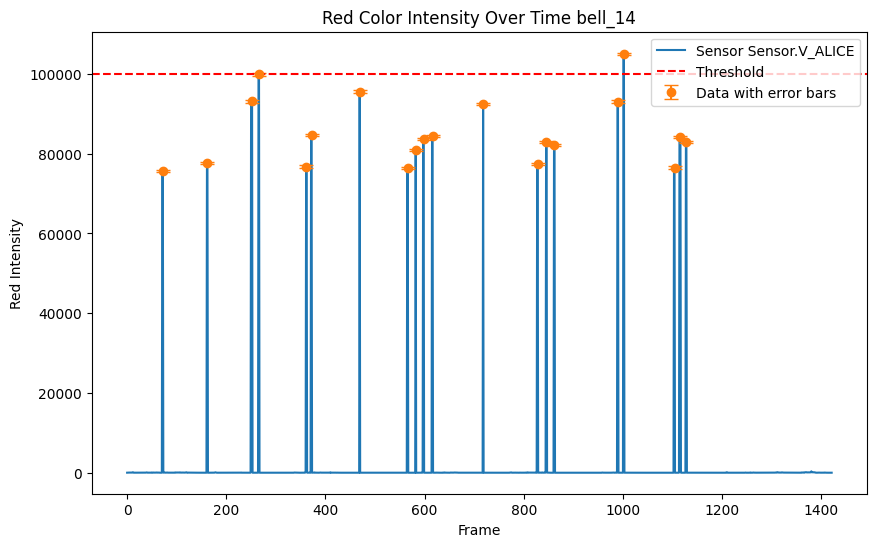

peak count 20


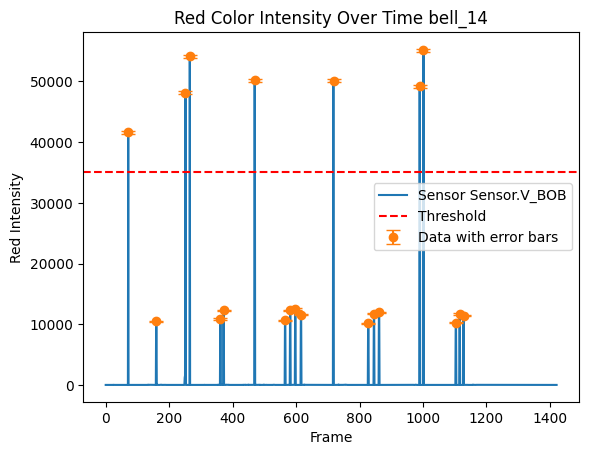

peak count 20


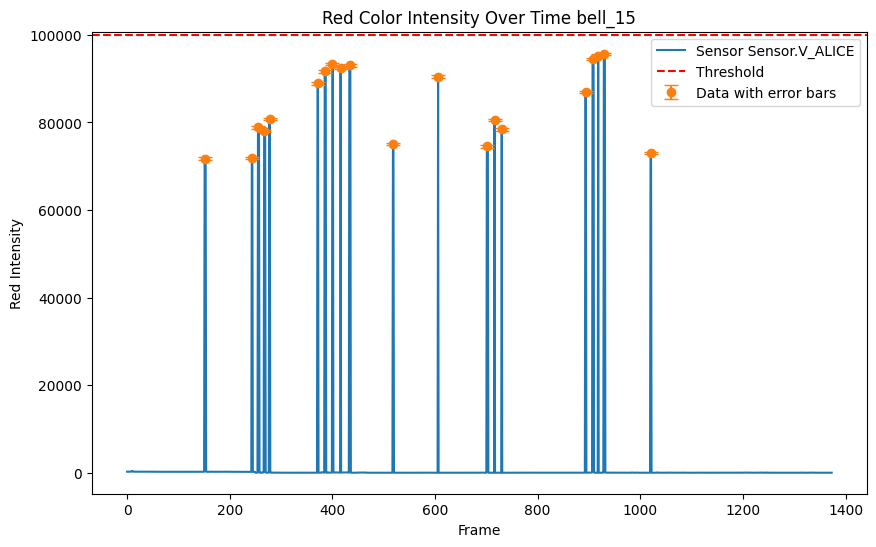

peak count 20


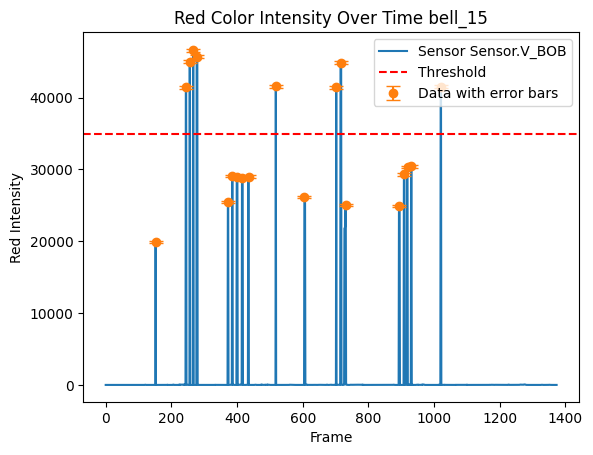

peak count 20


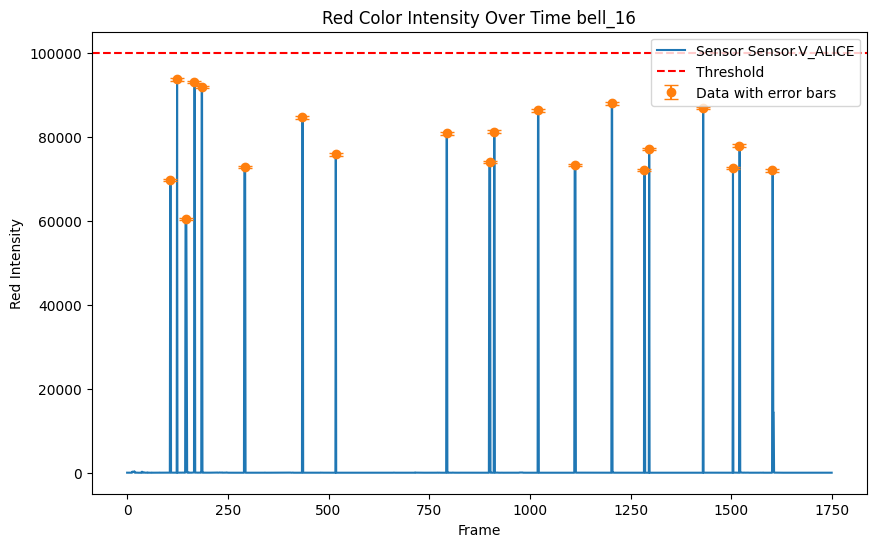

peak count 9


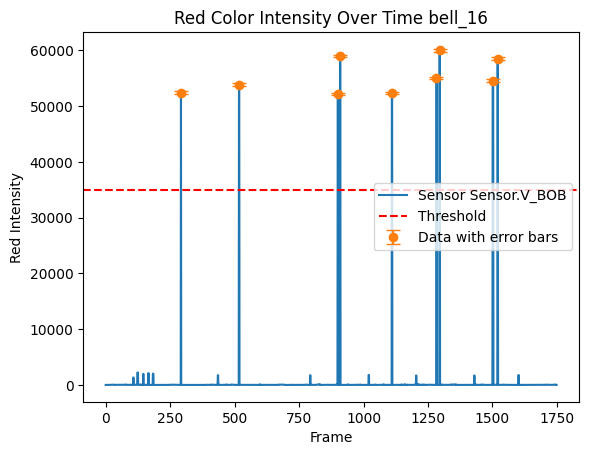

peak count 14


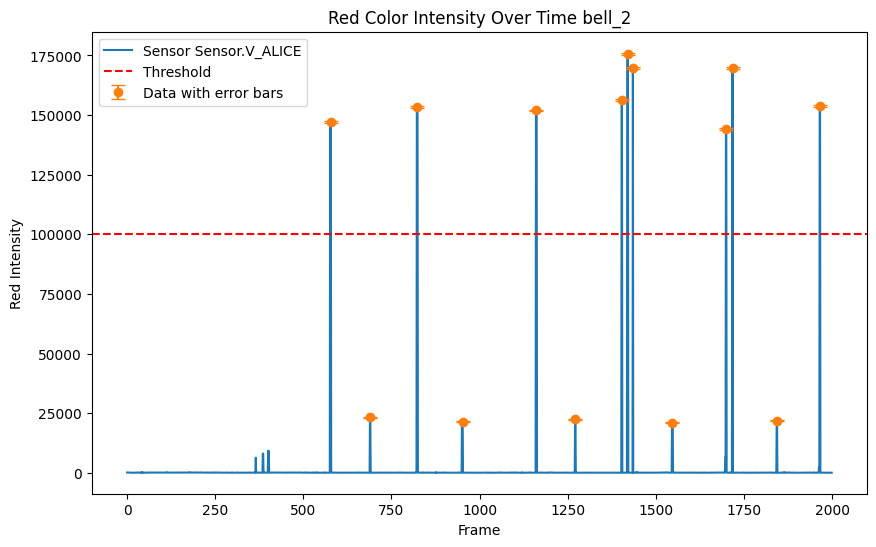

peak count 16


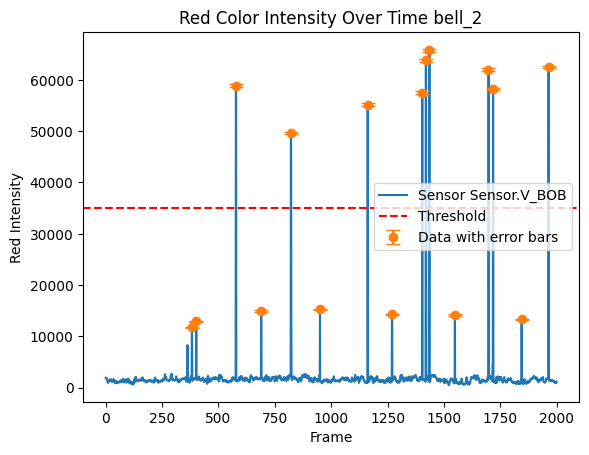

peak count 20


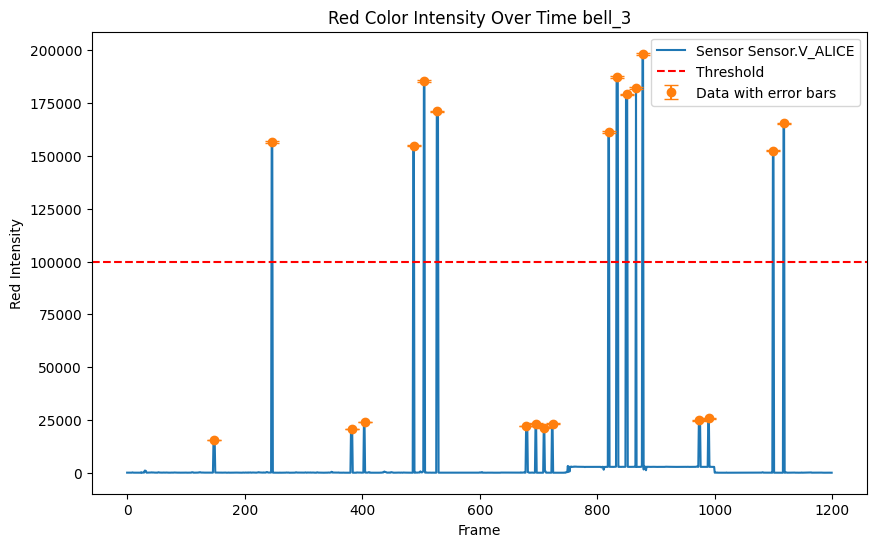

peak count 20


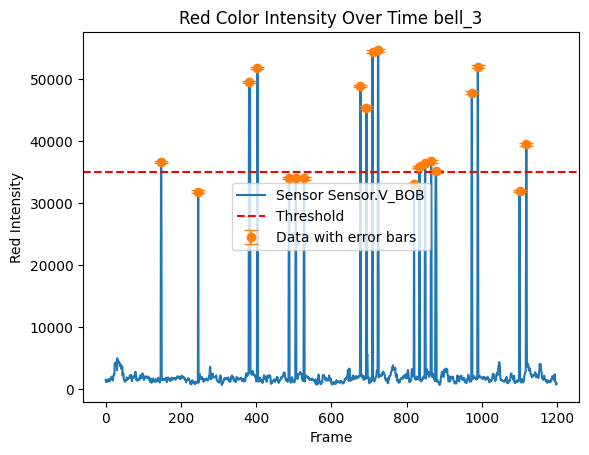

peak count 20


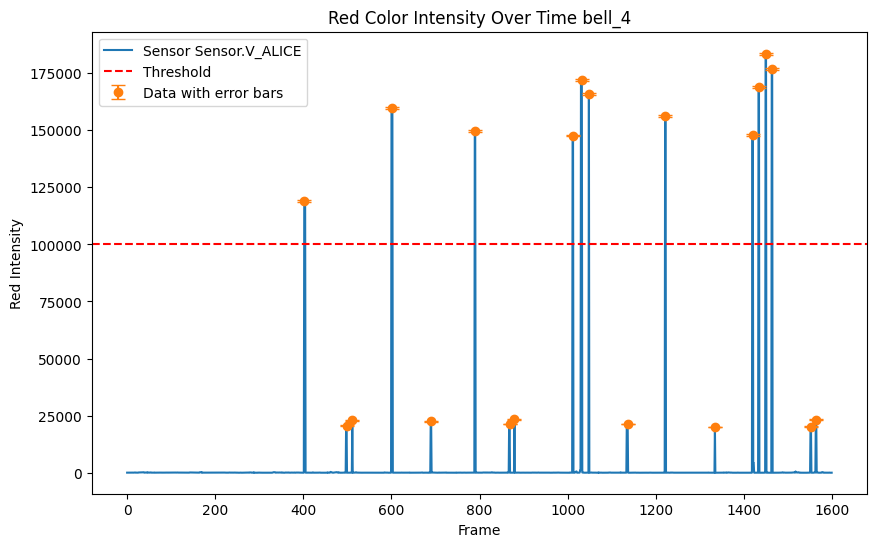

peak count 9


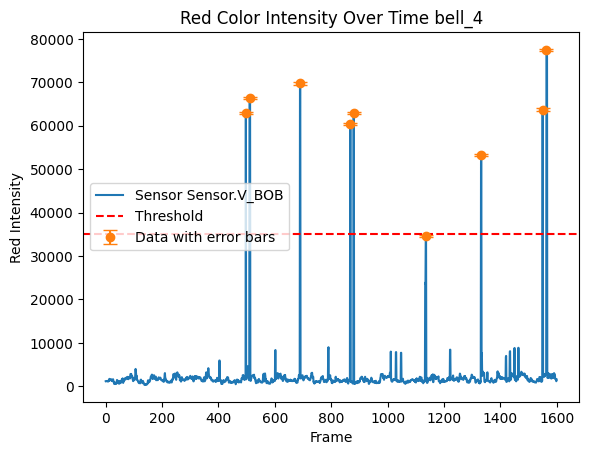

peak count 20


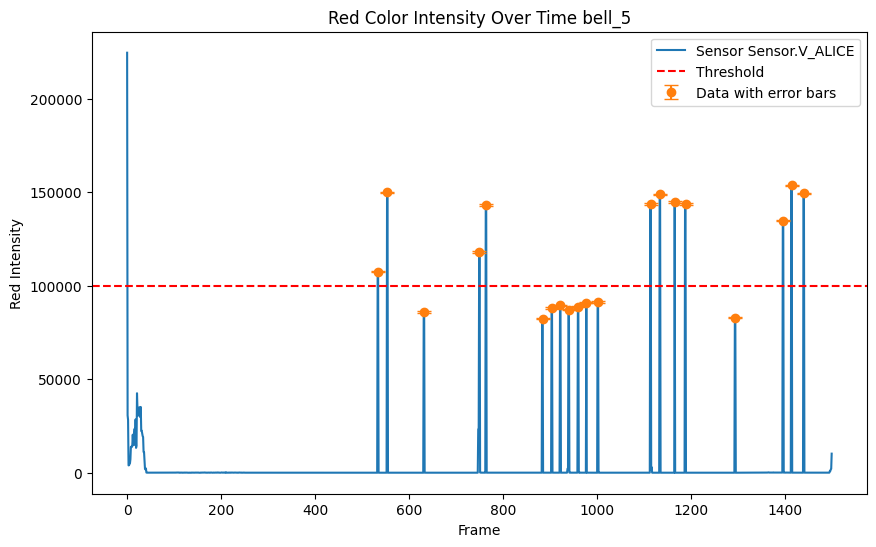

peak count 19


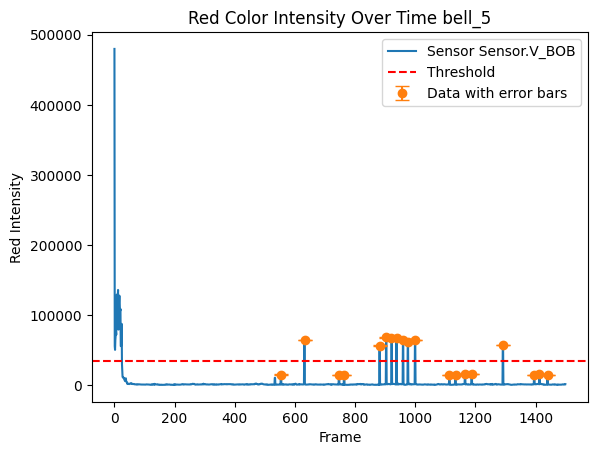

peak count 20


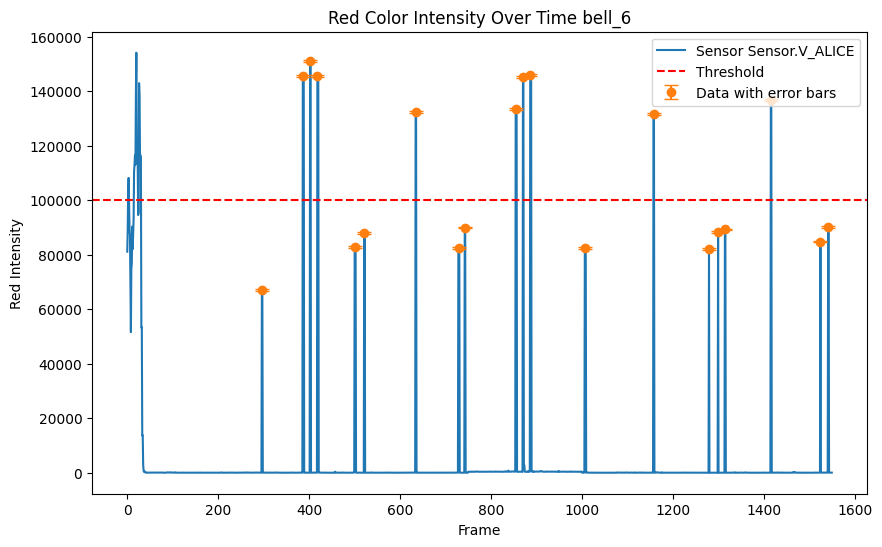

peak count 20


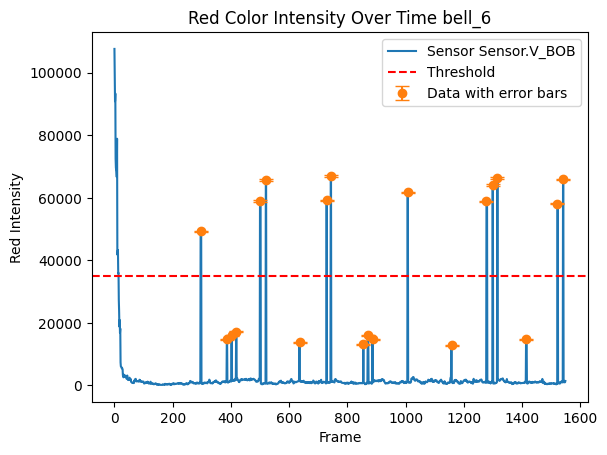

peak count 20


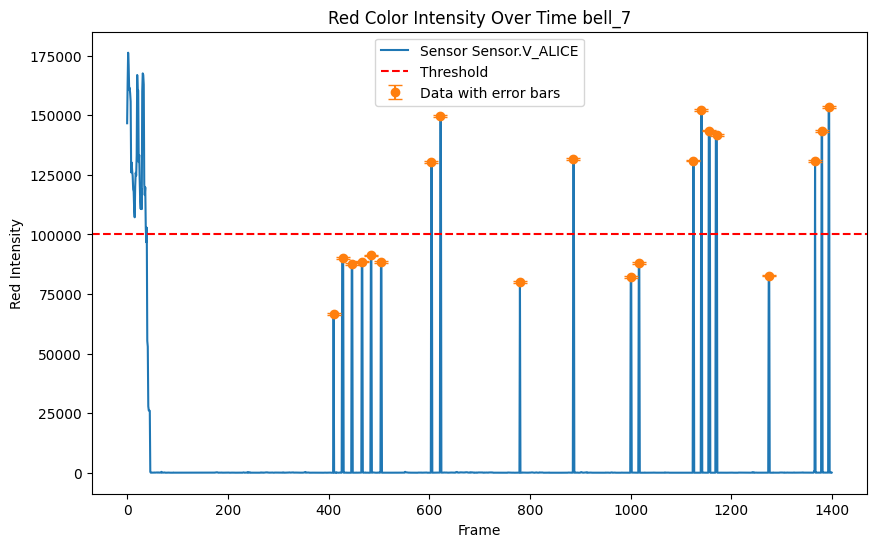

peak count 20


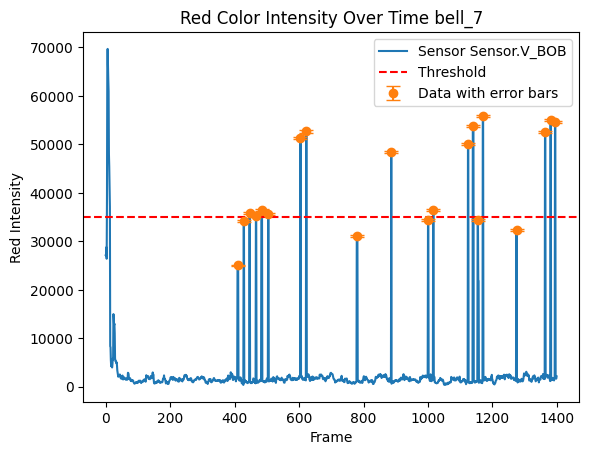

peak count 19


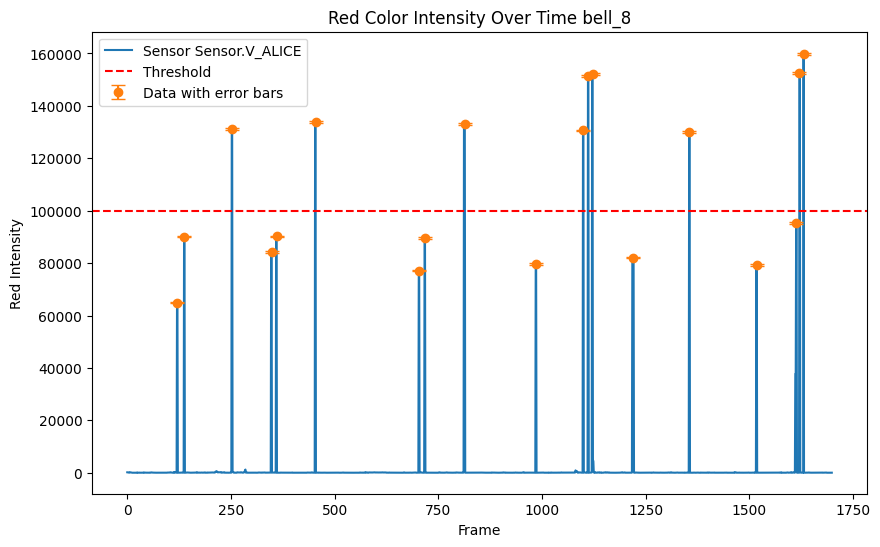

peak count 10


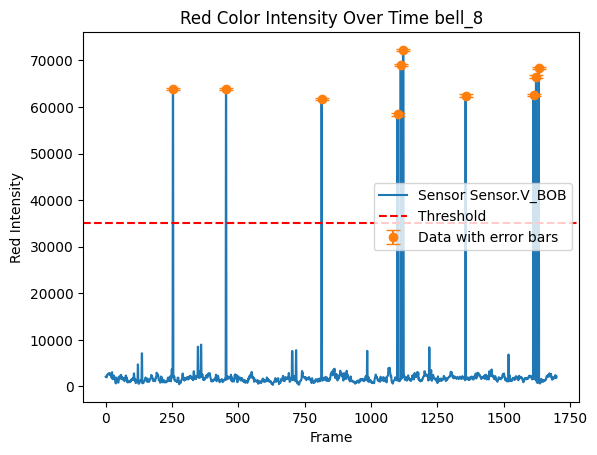

peak count 13


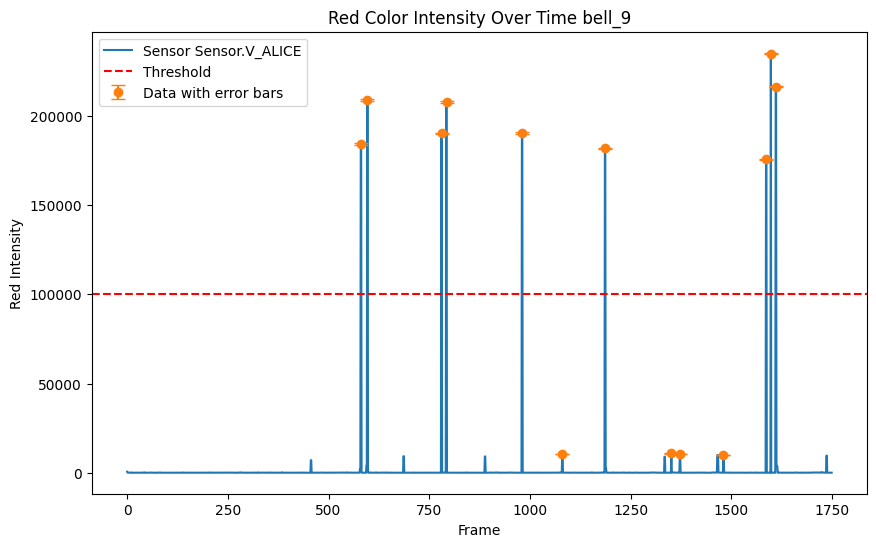

peak count 19


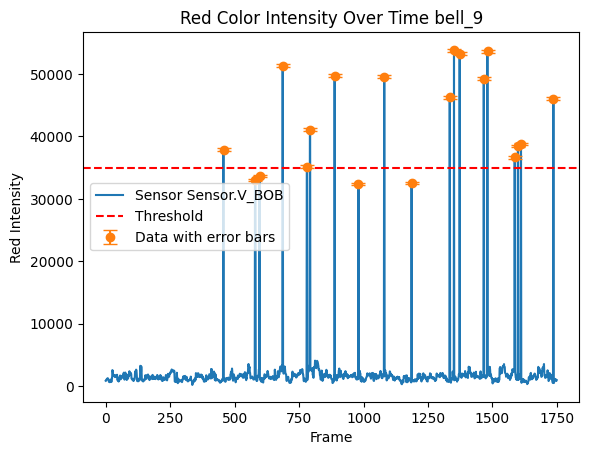

peak count 10


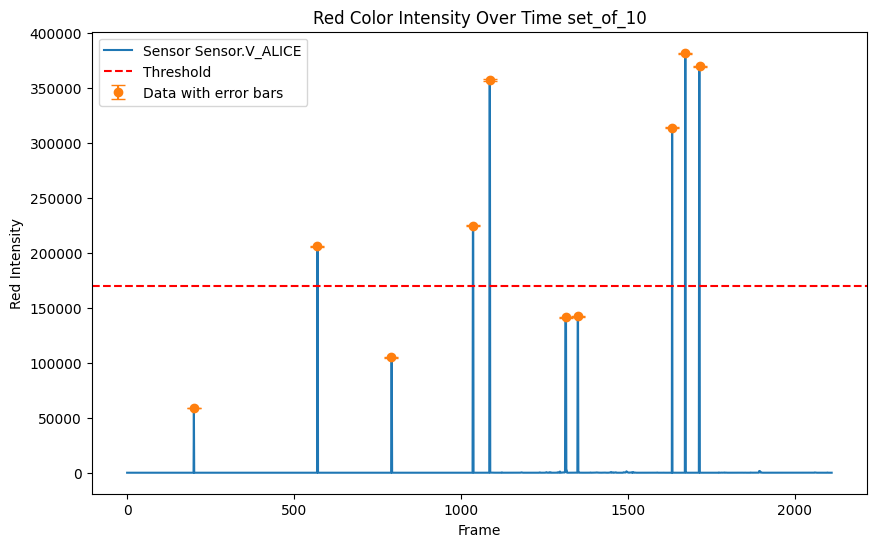

peak count 10


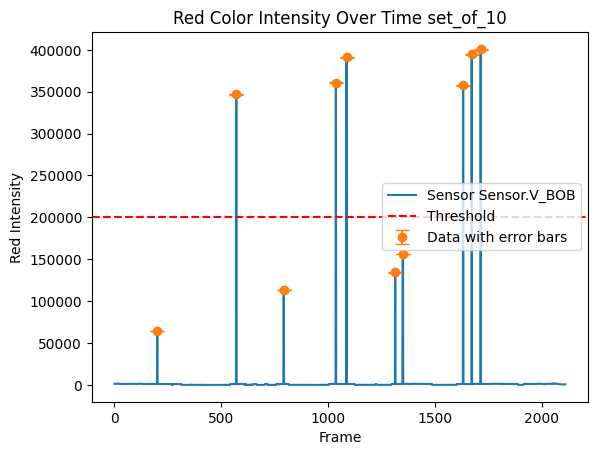

peak count 10


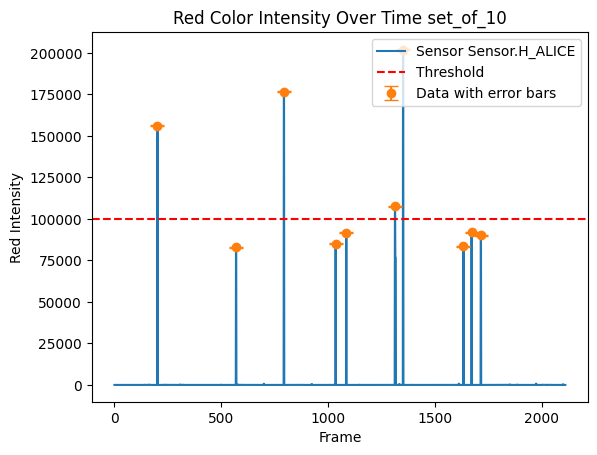

peak count 10


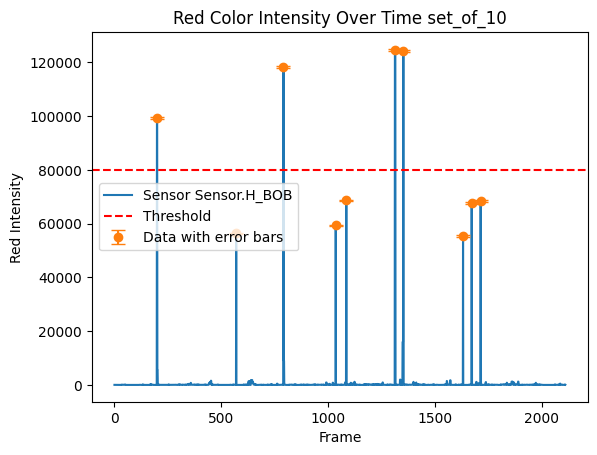

peak count 25


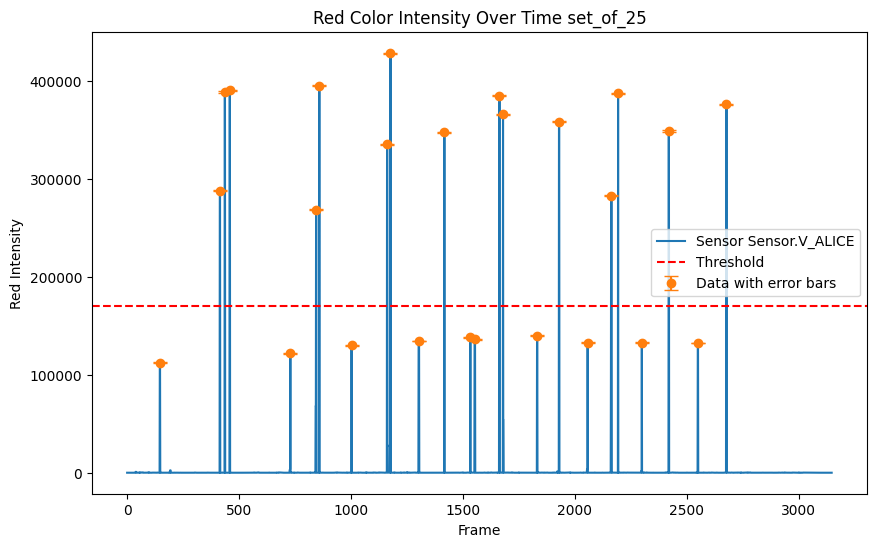

peak count 25


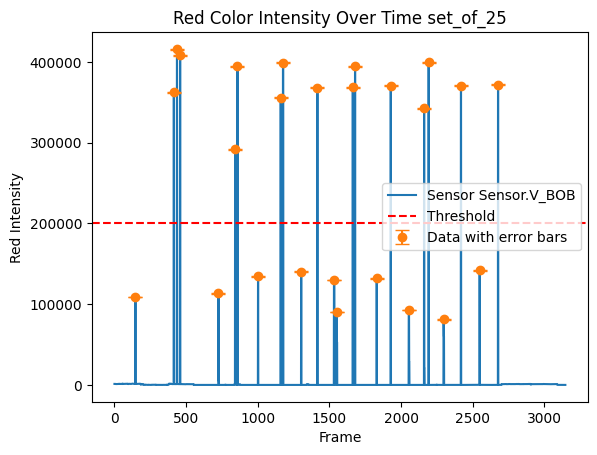

peak count 25


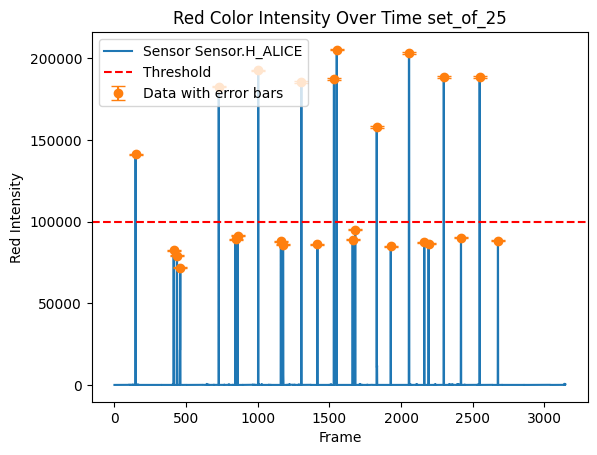

peak count 25


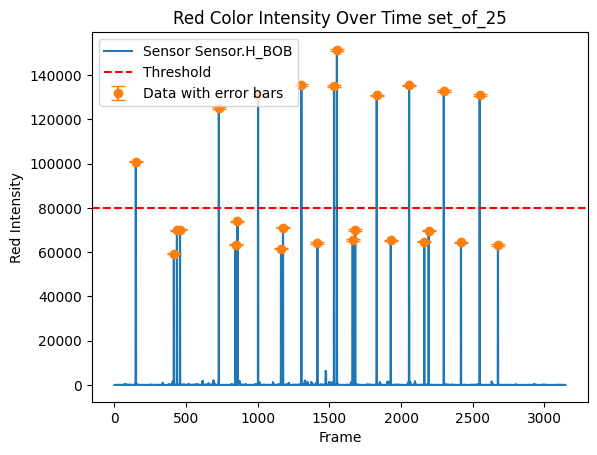

peak count 50


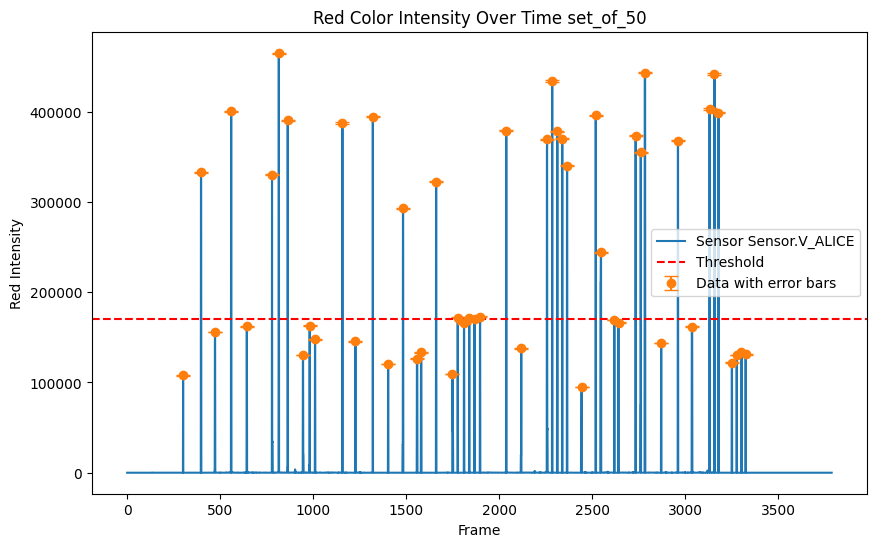

peak count 50


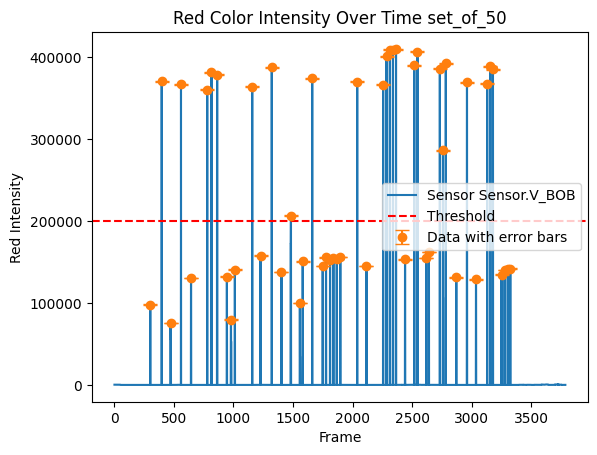

peak count 50


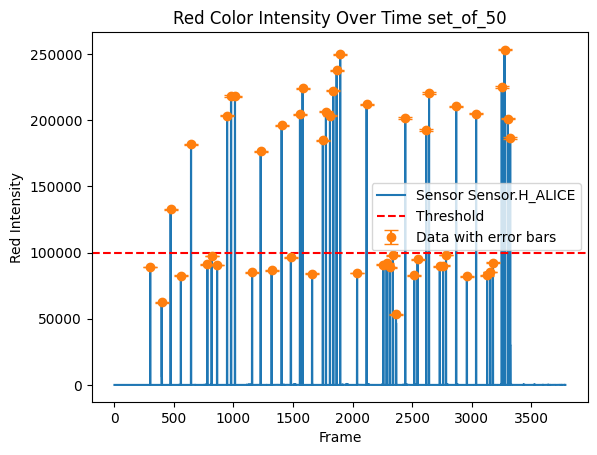

peak count 50


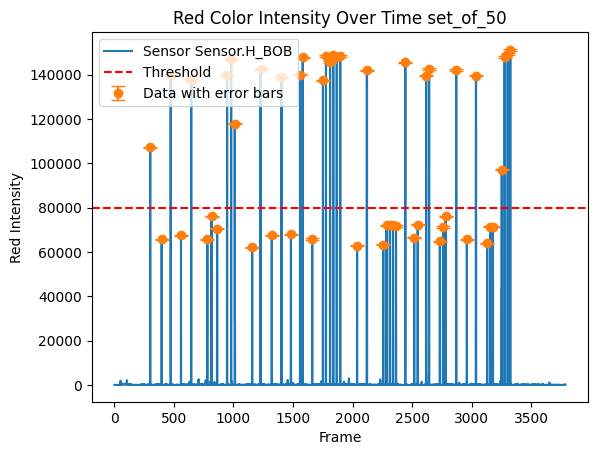

In [164]:

def moving_average(data, window_size=10):
    """
    Compute the moving average of a 1D list/array with a given window size.
    """
    if window_size <= 1:
        return data  # no smoothing if window size is 1 or less
    return np.convolve(data, np.ones(window_size), 'valid') / window_size


SENSOR_TO_THRESHOLD = {
    Sensor.V_ALICE: 170000,
    Sensor.V_BOB: 200000,
    Sensor.H_ALICE: 100000,
    Sensor.H_BOB: 80000,
}

SENSOR_TO_THRESHOLD_BELL_PER_EXP = {
    Sensor.V_ALICE: 100000,
    Sensor.V_BOB: 35000,
}

file_name_to_frame_range = {
    "bell_1": (0, 1500),
    "bell_2": (0, 2000),
    "bell_3": (0, 1200),
    "bell_4": (0, 1600),
    "bell_5": (100, 1500),
    "bell_6": (100, 1550),
    "bell_7": (250, 1400),
    "bell_8": (0, 1700),
    "bell_9": (0, 1750),
    "bell_10": (0, 1500),
    "bell_11": (100, 1300),
    "bell_12": (0, 1400),
    "bell_13": (0, 10000),
    "bell_14": (0, 10000),
    "bell_15": (0, 10000),
    "bell_16": (0, 1750),
}

exps = {}
exp_peaks_location = {}
for file_name, current_intensities in intensities.items():
    # Plot results
    plt.figure(figsize=(10, 6))
    # cap = cv2.VideoCapture(videos[0])
    sensor_to_data = {}
    sensor_to_peaks_location = {}
    for sensor, values in current_intensities.items():
        if "bell" in file_name:
            if sensor in [Sensor.H_BOB, Sensor.H_ALICE]:
                continue
        # values = moving_average(values, 3)
        peaks, _ = sp.signal.find_peaks(values, prominence=10000, width=(None, 10), distance=5)
        frame_range = file_name_to_frame_range.get(file_name, (0, 10000))
        peaks = [peak for peak in peaks if frame_range[0] < peak < frame_range[1]]
        sensor_to_peaks_location[sensor] = peaks

        peak_values = np.array(values)[peaks]
        y_err = np.sqrt(np.array(values)[peaks])

        if "bell" in file_name:
            threshold = SENSOR_TO_THRESHOLD_BELL_PER_EXP[sensor]
        else:
            threshold = SENSOR_TO_THRESHOLD[sensor]

        sensor_to_data[sensor] = [int(peak > threshold) for peak in peak_values]

        values = values[:frame_range[1]]
        plt.plot(np.arange(len(values)), values, label=f"Sensor {sensor}")
        plt.errorbar(np.arange(len(values))[peaks], np.array(values)[peaks], yerr=y_err, fmt='o', capsize=5,
                     label="Data with error bars")

        print(f"peak count {len(peaks)}")

        plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')

        plt.title(f"Red Color Intensity Over Time {file_name}")
        plt.xlabel("Frame")
        plt.ylabel("Red Intensity")
        plt.legend()
        plt.show()

    exps[file_name] = sensor_to_data
    exp_peaks_location[file_name] = sensor_to_peaks_location




# Reconstructing density matrix from experiment

In [291]:
from uncertainties.unumpy import uarray

set_of_10_exp = exps["set_of_10"]
set_of_25_exp = exps["set_of_25"]
set_of_50_exp = exps["set_of_50"]


def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv += [r'\end{bmatrix}']
    return '\n'.join(rv)




def get_density_matrix(sent_data, exp):
    counts = np.zeros((4, 4), dtype=int)
    for i, current_bit in enumerate(sent_data):
        row = 3 if current_bit else 0
        if exp[Sensor.V_BOB][i] and exp[Sensor.V_ALICE][i]:
            col = 0
        elif exp[Sensor.H_BOB][i] and exp[Sensor.V_ALICE][i]:
            col = 1
        elif exp[Sensor.V_BOB][i] and exp[Sensor.H_ALICE][i]:
            col = 2
        elif exp[Sensor.H_BOB][i] and exp[Sensor.H_ALICE][i]:
            col = 3
        else:
            print(i)
            print("undefined state")
            continue
        counts[row][col] += 1
    counts_with_error = uarray(counts, np.sqrt(counts))
    return counts_with_error / len(sent_data)

# assuming this is the first bell state, we can use symmetry to calculate the off diagonal element
def calculate_off_diagonal(mat):
    return mat + np.fliplr(mat)


print(bmatrix(calculate_off_diagonal(get_density_matrix(random_set1, set_of_10_exp))))
print(bmatrix(calculate_off_diagonal(get_density_matrix(random_set2, set_of_25_exp))))
print(bmatrix(calculate_off_diagonal(get_density_matrix(random_set3, set_of_50_exp))))





\begin{bmatrix}
  0.4+/-0.2 & 0.0+/-0 & 0.0+/-0 & 0.4+/-0.2\\
  0.0+/-0 & 0.0+/-0 & 0.0+/-0 & 0.0+/-0\\
  0.0+/-0 & 0.0+/-0 & 0.0+/-0 & 0.0+/-0\\
  0.6+/-0.2449489742783178 & 0.0+/-0 & 0.0+/-0 & 0.6+/-0.2449489742783178\\
\end{bmatrix}
\begin{bmatrix}
  0.4+/-0.1264911064067352 & 0.0+/-0 & 0.0+/-0 & 0.4+/-0.1264911064067352\\
  0.0+/-0 & 0.0+/-0 & 0.0+/-0 & 0.0+/-0\\
  0.0+/-0 & 0.0+/-0 & 0.0+/-0 & 0.0+/-0\\
  0.6+/-0.15491933384829668 & 0.0+/-0 & 0.0+/-0 & 0.6+/-0.15491933384829668\\
\end{bmatrix}
0
undefined state
\begin{bmatrix}
  0.48+/-0.09797958971132711 & 0.0+/-0 & 0.0+/-0 & 0.48+/-0.09797958971132711\\
  0.0+/-0 & 0.0+/-0 & 0.0+/-0 & 0.0+/-0\\
  0.0+/-0 & 0.0+/-0 & 0.0+/-0 & 0.0+/-0\\
  0.42+/-0.0916515138991168 & 0.08+/-0.04 & 0.08+/-0.04\\
  0.42+/-0.0916515138991168\\
\end{bmatrix}


# Calculating Bell's inequality

In [168]:
from uncertainties import ufloat

# Define the polarization angles from the PDF
angles = [
    (-45, -22.5),
    (-45, 22.5),
    (-45, 67.5),
    (-45, 112.5),
    (0, -22.5),
    (0, 22.5),
    (0, 67.5),
    (0, 112.5),
    (45, -22.5),
    (45, 22.5),
    (45, 67.5),
    (45, 112.5),
    (90, -22.5),
    (90, 22.5),
    (90, 67.5),
    (90, 112.5)
]

alpha_beta_to_N = {}

for i, current_angles in zip(range(1, 16 + 1), angles):
    exp_is_peaks = exps[f"bell_{i}"]
    exp_peak_locations = exp_peaks_location[f"bell_{i}"]

    v_bob_peak_locations = [x for is_peak, x in zip(exp_is_peaks[Sensor.V_BOB], exp_peak_locations[Sensor.V_BOB]) if
                            is_peak]
    v_alice_peak_locations = [x for is_peak, x in zip(exp_is_peaks[Sensor.V_ALICE], exp_peak_locations[Sensor.V_ALICE])
                              if is_peak]

    N = 0
    for bob_peak_x in v_bob_peak_locations:
        for alice_peak_x in v_alice_peak_locations:
            if abs(bob_peak_x - alice_peak_x) < 3:
                N += 1
    print(f"{current_angles} - {N}")
    alpha_beta_to_N[current_angles] = ufloat(N, N ** 0.5)


def get_perp_beta(beta):
    pairs = [(-22.5, 67.5), (22.5, 112.5)]

    for pair in pairs:
        if np.isclose(beta, pair[0]):
            return pair[1]
        elif np.isclose(beta, pair[1]):
            return pair[0]

    raise ValueError(f"Angle {beta} not found in defined pairs.")


def get_perp_alpha(alpha):
    pairs = [(-45, 45), (0, 90)]
    for pair in pairs:
        if np.isclose(alpha, pair[0]):
            return pair[1]
        elif np.isclose(alpha, pair[1]):
            return pair[0]

    raise ValueError(f"Angle {alpha} not found in defined pairs.")


def compute_E(N, alpha, beta):
    return (N[(alpha, beta)] + N[(get_perp_alpha(alpha), get_perp_beta(beta))] - N[(alpha, get_perp_beta(beta))] - N[
        (get_perp_alpha(alpha), beta)]) / (
            N[(alpha, beta)] + N[(get_perp_alpha(alpha), get_perp_beta(beta))] + N[(alpha, get_perp_beta(beta))] +
            N[(get_perp_alpha(alpha), beta)])


a = 0
a_tag = 45
b = 22.5
b_tag = 67.5

S = (compute_E(alpha_beta_to_N, a, b) - compute_E(alpha_beta_to_N, a, b_tag) + compute_E(alpha_beta_to_N, a_tag, b) +
     compute_E(
         alpha_beta_to_N, a_tag, b_tag))
print(S)

(-45, -22.5) - 8
(-45, 22.5) - 8
(-45, 67.5) - 5
(-45, 112.5) - 0
(0, -22.5) - 0
(0, 22.5) - 0
(0, 67.5) - 9
(0, 112.5) - 9
(45, -22.5) - 5
(45, 22.5) - 0
(45, 67.5) - 10
(45, 112.5) - 9
(90, -22.5) - 11
(90, 22.5) - 1
(90, 67.5) - 0
(90, 112.5) - 0
-2.71+/-0.18


# Density Matrix Simulation

In [292]:


import numpy as np
import qutip as qt

# Define basis states
H = qt.basis(2, 0)  # Horizontal polarization |H>
V = qt.basis(2, 1)  # Vertical polarization |V>

# Define measurement bases
D = (H + V).unit()  # Diagonal |D>
A = (H - V).unit()  # Anti-diagonal |A>
R = (H - 1j * V).unit()  # Right circular |R>
L = (H + 1j * V).unit()  # Left circular |L>

bases = [H, V, D, A, R, L]

# Define an arbitrary state |ψ⟩ = cos(θ/2)|H> + exp(iϕ) sin(θ/2)|V>
theta = np.pi / 4  # Example angle
phi = np.pi / 3  # Example phase


def get_psi():
    return (V + H) / np.sqrt(2)


# Compute the true density matrix
rho_true = get_psi() * get_psi().dag()

# Define Pauli matrices and Identity
sigma_0 = qt.qeye(2)
sigma_x = qt.sigmax()
sigma_y = qt.sigmay()
sigma_z = qt.sigmaz()

# Number of simulated photons
num_photons = 1000
n_s = np.zeros(4)

base_to_count = np.zeros(len(bases))

for i in range(num_photons):
    psi = get_psi()
    for j, base in enumerate(bases):
        m, _ = qt.measurement.measure(psi, base * base.dag())
        if m:
            base_to_count[j] += 1

n_s[0] = base_to_count[bases.index(H)] + base_to_count[bases.index(V)]
n_s[1] = base_to_count[bases.index(D)] - base_to_count[bases.index(A)]
n_s[2] = base_to_count[bases.index(L)] - base_to_count[bases.index(R)]
n_s[3] = base_to_count[bases.index(H)] - base_to_count[bases.index(V)]

# # Compute Stokes parameters
S = n_s
S /= S[0]

print(S)
# Reconstruct the density matrix
rho_reconstructed = 0.5 * (np.dot(np.array([sigma_0, sigma_x, sigma_y, sigma_z]), S))
print("Single Qbit calculated density matrix")
print(rho_true)
print("Reconstructed Qbit density matrix")
print(rho_reconstructed)

# Convert to analogs qbit pair bell state
mat = np.zeros((4,4))
for x,y in itertools.product([0, -1], repeat=2):
    mat[x,y] = rho_reconstructed[x,y]

print("Reconstructed Qbit density matrix - modified to be qbit pair")
print(mat)
    






[ 1.          0.97087379  0.00873786 -0.00194175]
Single Qbit calculated density matrix
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.5 0.5]
 [0.5 0.5]]
Reconstructed Qbit density matrix
Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.49902913+0.j         0.48543689-0.00436893j]
 [0.48543689+0.00436893j 0.50097087+0.j        ]]
Reconstructed Qbit density matrix - modified to be qbit pair
[[0.49902913 0.         0.         0.48543689]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.48543689 0.         0.         0.50097087]]


C:\Users\30109\AppData\Local\Temp\ipykernel_65068\495428356.py:69: ComplexWarning: Casting complex values to real discards the imaginary part
  mat[x,y] = rho_reconstructed[x,y]
